# Goal

The goal of this script is to extract a row from the `StakeholderDino_FRs.csv` spreadsheet, which relates to the functional requirements discussed as part of a single unstructured interview, and to represent the contents of that row pictorially. The true goal of which, is to allow the interviewees to confirm whether we have truly captured their requirements in a less complicated manner than requiring them to wrap their heads around the master spreadsheet format.

As always, start by importing modules, including the previously unused/lesser known [DataMapPlot](https://datamapplot.readthedocs.io/en/latest/index.html), which will be crucial for building an interactive mindmap-style plot. [Random](https://docs.python.org/3/library/random.html) allows for the generation of _pseudo_-random numbers.

__Potential issue__

The outputted html is being reported (by Teams, Safari and Outlook) as containing malware. This is despite the package being [actively maintained on Github](https://github.com/TutteInstitute/datamapplot) and promoted through [matplotlib's third party package listings](https://matplotlib.org/thirdpartypackages/). Although its not impossible that it contains malware, it is unlikely.

__Issue resolved__

Bypassing the issue by instead setting up a repository in Github which uses Pages to host the plots.

# Initiatate

In [25]:
import numpy as np
import pandas as pd
import datamapplot
from collections import Counter
import colorcet as cc #A set of useful perceptually uniform colormaps for plotting scientific data: https://colorcet.holoviz.org/ & https://github.com/holoviz/colorcet
import os

# Design
To use DataMapPlot, a set of 2D coordinates (such as a 2D numpy array) and a list of labels, one for each coordinate pair is required. As we wish to make a map where the coordinates form a circle, we shall try to employ polar coordinates as part of a for loop. The number of positions that need generating relates to the number of top-level 'attributes' in the [master spreadsheet](https://livemanchesterac.sharepoint.com/:x:/r/sites/UOM-RIT-RLP/Shared%20Documents/New%20RLP/Open,%20Reproducible%20and%20Responsible%20Research/ORR12%20Digital%20Notebooks%20%26%20Sample%20Inventories/02%20Definition/Functional%20Requirements/Stakeholders_FRs_Bens.xlsm?d=w9d0e97af6a054764832f14b4d0730ed5&csf=1&web=1&e=N3aDly), as depicted in the innermost circle of [Miro](https://miro.com/app/board/uXjVLdds0oo=/?share_link_id=490665046930). Hence, the most sustainable way to produce the plot requires reading in data from the spreadsheet.

In [26]:
#Import each csv (exported from spreadsheets elsewhere to contain only minimum viable data)
attrib_df = pd.read_csv('./data/ERNAttributeDefinition.csv')
entries_df = pd.read_csv('./data/DefaultAttributeEntries.csv')
stakeholders_df = pd.read_csv('./data/Stakeholder_ERN_FRs.csv',sep=';')
entries_df

,TL-01,G-01,U-01,U-02,U-03,CF-01,CF-02,CF-04,CF-05,CF-06,...,C-02,EF-01,EF-02,EF-03,EF-05,EF-06,IT-01,IT-02,IT-03,IT-04
0,Benchling Notebook,AGPL 3.0,No,Amharic,Online documentation,Annotation,All formats,Complete content in document format,Define own templates,Advanced/conditional search,...,ADA,Asset management,Create own plug-ins,Autoupload/folder watch,Calendar,Cross-project workflows,Command line input,No,Browser based,Cloud of own choice
1,Genemod,Apache 2.0,Unknown,Bengali,"User training (online, on site)",Barcode Scanner,Audio formats,Complete content in machine readable format,Import from internet sources,BLAST Search,...,ASTM,Freezer Management,In-house plugins,Business Logics,NaN,Export possible,Java API,Unknown,Local client,Local
2,Labfolder (Labforward),Closed Source,Yes,Dutch,Support by provider (Consulting),Browser forms,Database formats,Direct publication option,Import of own templates,Database queries,...,CROMERRR,Instrument management,On request,Data analysis,Taskboard,Graphical,NaN,Yes,Mobile Application,Provider's Cloud
3,LabID,MIT,NaN,Egyptian Spoken Arabic,NaN,Chemical editor/sketching,Direct only (CF-01),Formats suitable for long term archiving,Microtitre plate templates,File/data hierarchy,...,FDA CFR 21 Part 11,Inventory (devices),Other vendor products,Device control,Task management,Import possible,ODBC,NaN,Responsive Design,NaN
4,Labstep,Mozilla Public Licence 2.0,NaN,English,NaN,Dictation function,Document formats,Formats suitable for publication,Subject specific templates,Filtering,...,FERPA,LIMS connectivity,Widgets,NaN,Unknown,No,Other API,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Sapio Platform (Triple Play),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,SnapGene (Dotmatics),NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,SciCord,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Teams,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Sciformation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,VisioNize sense (Eppendorf ),NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,Scilligence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Winchat,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Note that the folder containing the .csv files is not named `_data`, as is more commonly the case [when building Jekyll sites](https://jekyllrb.com/docs/step-by-step/06-data-files/#data-file-usage). This is because reading the .csv files currently contained in there was generating an error that meant that Github would not generate the site via Actions. I think the error was due to a csv parsing issue, for which the solution may lie on [this page](https://jekyllrb.com/docs/datafiles/#the-data-folder).

## Pre-process entries_df

Process the attributes with codenames: __G-01__, __EF-02__ , __EF-03__ and __U-03__.

### G-01

- For level 2, we categorize all non-closed-source items as _Open source_. This results in two groups: _Open source_ and _Closed source_.

- For level 3, we reclassify the Open Source responses under _Others_, which represents other open-source items without specific identification.

### EF-02

- For level 2, we categorize all integrations and extensions items into 13 distinct categories, with some items assigned to more than one category.

- For level 3, we use Roman numerals to encode duplicate items, addressing the issue of items appearing in incorrect positions in Matplotlib due to its default behavior of using centroids.

### EF-03

We relegate the _API_ functional attribute (__IT_01__) to below the top-level, and instead make it a sub-level attribute of _Automation_ (__EF-03__). We therefore remove __IT-01__ altogether, along with __TL-01__ which contains a list of many known notebook softwards, included specialised electronic research and laboratory notebooks, as well as general note-taking apps.

### U-03

Correct misc labelling discrepancies.


In [ ]:
# G-01
G_01_l3 = entries_df['G-01'].dropna()
entries_df['G-01'] = entries_df['G-01'].apply(
    lambda x: "Open source" if isinstance(x, str) and x != 'Closed Source' else ("Closed source" if isinstance(x, str) and x == 'Closed Source' else pd.NA))
is_duplicated = entries_df['G-01'].duplicated()

entries_df.loc[is_duplicated, 'G-01'] = pd.NA
G_01_l3=G_01_l3[G_01_l3!='Closed Source']

G_01_l3[G_01_l3!='Open Source'] = 'Others'


#EF-02

Publication= ['BioMed Central (Springer Nature)', 'Dataverse', 'DSpace', 'eLife', 'F1000Research', 'FAIRDOM',
                     'Figshare','Galaxy','Github','JoVE', 'MethodsX (Elsevier)', 'Protocols.io']

CloudStorage = ['Dropbox','Egnyte','Elemental Machines','Google Drive','Microsoft Office Plug-in','One Drive' ]

LabManagement = ['Atlas CDS (Thermo Fisher Scientific)','CAS SciFinder (ACS)','Elemental Machines', 'iLab (Agilent)',
                       'Label printing (FLUICS)','Label Printing (Other)','RackScan Analyzer (Eppendorf)','SafeCode System (Eppendorf)',
                       'VisioNize sense (Eppendorf)']

DataAnalysis = ['Atlas CDS (Thermo Fisher Scientific)','ChemDoodle (iChemLabs)','ChemDraw (Revvity Signals)','Dataverse','FlowJo (BD)',
                      'Galaxy','Github','GraphPad Prism (Dotmatics)','ImageJ','Immunarch (ImmunoMind)','JS Mol','Jupyter (Notebook & Lab)',
                      'JupyterHub','Ketcher Editor','Logger Pro (Vernier)','Marvin JS (ChemAxon)','MarvinSketch (ChemAxon)',
                      'MassHunter (Agilent)','Microsoft Office Plug-in','mpVision (Modicus Prime)','OpenBabel','PlasMapper',
                      'Polygon AI (Rewire Neuro)','Quality Analyst (Northwest Analytics)','rakit','SAP BTP','SnapGene (Dotmatics)']

DataVisualisation = ['Atlas CDS (Thermo Fisher Scientific)','ChemDoodle (iChemLabs)','ChemDraw (Revvity Signals)','FlowJo (BD)','Galaxy',
                    'GraphPad Prism (Dotmatics)','ImageJ','JS Mol','Jupyter (Notebook & Lab)','JupyterHub','Ketcher Editor',
                    'Logger Pro (Vernier)','Marvin JS (ChemAxon)','MarvinSketch (ChemAxon)','Microsoft Office Plug-in',
                    'Mind the Graph (Cactus)','OpenBabel','PlasMapper','Polygon AI (Rewire Neuro)','Pubchem (NLM)',
                    'Quality Analyst (Northwest Analytics)','SnapGene (Dotmatics)']

DataImport = ['Atlas CDS (Thermo Fisher Scientific)','Biobank','BioMed Central (Springer Nature)','CAS SciFinder (ACS)',
                    'ChemDoodle (iChemLabs)','ChemDraw (Revvity Signals)','Dataverse', 'iLab (Agilent)','Ketcher Editor',
                    'Label printing (FLUICS)','Label Printing (Other)','LabX (Mettler Toledo)','Logger Pro (Vernier)','Marvin JS (ChemAxon)',
                    'MarvinSketch (ChemAxon)','MassHunter (Agilent)','OpenBabel','PlasMapper','Polygon Al (Rewire Neuro)','Pubchem (NLM)',
                    'RackScan Analyzer (Eppendorf)','rdkit','SafeCode System (Eppendorf)','SAP BTP','SnapGene (Dotmatics)',
                    'VisioNize sense (Eppendorf)','Winchat']

DataManagementPlanning = ['DMP Tool']

Coding = ['Github','JS Mol','Jupyter (Notebook & Lab)', 'JupyterHub', 'rdkit']

ReferenceManagement = ['Mendeley (Elsevier)','Zotero']

DocumentFormatting = ['GoogleDocs','InDesign (Adobe)','Libre Office','Microsoft Office Plug-in']

Collaboration = ['Box','Dataverse','Dropbox','Egnyte','Google Drive','GoogleDocs','Microsoft Office Plug-in','OneNote','Protocols.io',
                'SAP BTP','Slack','SnapGene (Dotmatics)','Teams']

InstrumentControl = ['Atlas CDS (Thermo Fisher Scientific)','Labx (Mettler Toledo)','MassHunter (Agilent)','RackScan Analyzer (Eppendorf)',
             'SafeCode System (Eppendorf)','VisioNize sense (Eppendorf)']

ProjectManagement = ['CAS SciFinder (ACS)','Evernote','Github','OneNote','SAP BTP']

EF_02_l2_attr = [
    Publication, CloudStorage,LabManagement,DataAnalysis,
             DataVisualisation,DataImport, DataManagementPlanning,
             Coding,ReferenceManagement,DocumentFormatting,
             Collaboration,InstrumentControl,ProjectManagement
             ]
EF_02_l2 = [
    'Publication', 'CloudStorage', 'LabManagement', 'DataAnalysis',
    'DataVisualisation', 'DataImport', 'DataManagementPlanning',
    'Coding', 'ReferenceManagement', 'DocumentFormatting',
    'Collaboration', 'InstrumentControl', 'ProjectManagement'
]
 
# Create 'EF-02' level 2 category
EF_02_l2 = EF_02_l2 + [None]*(len(entries_df)-len(EF_02_l2))
entries_df['EF-02'] = EF_02_l2
 
# Find elements in more than 1 'EF-02' level 2 category
all_EF_02 = [item for sublist in EF_02_l2_attr for item in sublist]
item_counts = Counter(all_EF_02)
print(item_counts)
duplicates = [item for item, count in item_counts.items() if count > 1]
 
# Encode duplicate items to make them unique
Roman_numerals = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']
for duplicate in duplicates:
    i=0
    for idx1, sub in enumerate(EF_02_l2_attr):
        if duplicate in sub:
            idx2 = sub.index(duplicate)
            EF_02_l2_attr[idx1][idx2] = duplicate + '-' + Roman_numerals[i]
            i+=1
print(DataVisualisation)

#EF-03
EF_03_l3 = entries_df['IT-01'].dropna()

#Add the value "API" to 'EF-03' column of entries_df
entries_df.loc[len(entries_df['EF-03'].dropna())+1, 'EF-03'] = "API"
        

#Remove 'TL-01', 'IT-01' following above
attrib_df = attrib_df[~attrib_df['ID'].isin(['TL-01', 'IT-01'])]
entries_df = entries_df.drop(['TL-01', 'IT-01'],axis=1) 

# U-03
entries_df['U-03']=entries_df['U-03'].str.replace('User training (online, on site)','User training (online/on site)')

Counter({'Microsoft Office Plug-in': 5, 'Atlas CDS (Thermo Fisher Scientific)': 5, 'Dataverse': 4, 'Github': 4, 'SAP BTP': 4, 'SnapGene (Dotmatics)': 4, 'Galaxy': 3, 'CAS SciFinder (ACS)': 3, 'RackScan Analyzer (Eppendorf)': 3, 'SafeCode System (Eppendorf)': 3, 'VisioNize sense (Eppendorf)': 3, 'ChemDoodle (iChemLabs)': 3, 'ChemDraw (Revvity Signals)': 3, 'JS Mol': 3, 'Jupyter (Notebook & Lab)': 3, 'JupyterHub': 3, 'Ketcher Editor': 3, 'Logger Pro (Vernier)': 3, 'Marvin JS (ChemAxon)': 3, 'MarvinSketch (ChemAxon)': 3, 'MassHunter (Agilent)': 3, 'OpenBabel': 3, 'PlasMapper': 3, 'BioMed Central (Springer Nature)': 2, 'Protocols.io': 2, 'Dropbox': 2, 'Egnyte': 2, 'Elemental Machines': 2, 'Google Drive': 2, 'iLab (Agilent)': 2, 'Label printing (FLUICS)': 2, 'Label Printing (Other)': 2, 'FlowJo (BD)': 2, 'GraphPad Prism (Dotmatics)': 2, 'ImageJ': 2, 'Polygon AI (Rewire Neuro)': 2, 'Quality Analyst (Northwest Analytics)': 2, 'Pubchem (NLM)': 2, 'rdkit': 2, 'GoogleDocs': 2, 'OneNote': 2, 'DSp

### Labelling
Attempt to fix Github issue \# 3 :[_Unusual labelling_](https://github.com/oiseau-lab/research-notebooks/issues/3). The issue arises where data points have exactly equivalent names.

- Fix #1 - Rename repeats

JB is going to attempt to change

In [ ]:

fix_03 = ['Yes','No','Unknown','On request'] #Create a list of the problematic entries

x = entries_df.shape[0] # rows number
y = entries_df.shape[1] # columns number

# Loop through the entries_df and encode name to items in fix_03
cols = entries_df.columns
for i in range(x):
    for j in range(y):
        if not pd.isna(entries_df.iloc[i, j]) and entries_df.iloc[i, j] in fix_03:
            entries_df.iloc[i, j] = entries_df.iloc[i, j] + '-' + cols[j]

### Rename top-level (L1) attributes.

In [31]:
old_name = attrib_df['ID']
new_name = attrib_df['Name of  Attributes']
rename_dict = dict(zip(old_name, new_name))
entries_df.rename(columns=rename_dict,inplace=True )
entries_df

,License,Customizable user interface,Languages,Support,Data input,Data import (formats),Data export,Templates,Searchability,Collaboration,Preservation of evidence,Compliance,Laboratory management functions,Integrations and extensions,Automation,(Individual) Project management tools,Workflows,Controlled vocabulary,Data access (client),Data storage location
0,Open source,No-U-01,Amharic,Online documentation,Annotation,All formats,Complete content in document format,Define own templates,Advanced/conditional search,Comments,Audit Trail,ADA,Asset management,Publication,Autoupload/folder watch,Calendar,Cross-project workflows,No-IT-02,Browser based,Cloud of own choice
1,<NA>,Unknown-U-01,Bengali,User training (online/on site),Barcode Scanner,Audio formats,Complete content in machine readable format,Import from internet sources,BLAST Search,External guest permitted,Electronic signature,ASTM,Freezer Management,CloudStorage,Business Logics,NaN,Export possible,Unknown-IT-02,Local client,Local
2,Closed source,Yes-U-01,Dutch,Support by provider (Consulting),Browser forms,Database formats,Direct publication option,Import of own templates,Database queries,Notifications,Locking,CROMERRR,Instrument management,LabManagement,Data analysis,Taskboard,Graphical,Yes-IT-02,Mobile Application,Provider's Cloud
3,<NA>,NaN,Egyptian Spoken Arabic,NaN,Chemical editor/sketching,Direct only (CF-01),Formats suitable for long term archiving,Microtitre plate templates,File/data hierarchy,Real-time collaboration,Timestamping,FDA CFR 21 Part 11,Inventory (devices),DataAnalysis,Device control,Task management,Import possible,NaN,Responsive Design,NaN
4,<NA>,NaN,English,NaN,Dictation function,Document formats,Formats suitable for publication,Subject specific templates,Filtering,Rights management,Unknown-C-01,FERPA,LIMS connectivity,DataVisualisation,NaN,Unknown-EF-05,No-EF-06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
65,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
66,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
67,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


## Mapping

Now to create an array of 2D coordinates corresponding to the number of attributes in the sheet, which are currently contained in the dataframe labelled `attrib_df`.

In [32]:
#Function for polar to cartesian conversion.
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
rho=1 #Fix radius
arr_length = len(attrib_df)
arr = np.empty((arr_length, 2)) #Create empty array


for idx in range(arr_length):
    phi = idx/(arr_length) * (2*np.pi)
    arr[idx] = pol2cart(rho,phi)

Find the distance between two points to be able to define a smaller radius, r<sub>2</sub>, which can be used to set the boundary for the points to be distributed within a circular region around each level one centrepoint (i.e. the coordinates already given in the array).


In [33]:
#calculate the distance between two points of level 1.
diff = arr[0]-arr[1]
print(diff,diff[0],diff[1])
dist = np.sqrt(diff[0]**2+diff[1]**2)

[ 0.04894348 -0.30901699] 0.04894348370484647 -0.3090169943749474


With the distance, can set the limit of r<sub>2</sub>. Calculate the centroids of all elements and store them in the 'new_arr'. Also, store level1 and level2 labels in the 'l1_labels' list and 'l2_labels' list, respectively.



In [34]:
new_arr = []
l1_labels = []
l2_labels = []
l3_labels = []
hover_labels = []

for idx1, column in enumerate(entries_df):
    
        coord_origin = arr[idx1]
        entries = entries_df[str(column)]
        entries = entries.dropna()
        entry_count =len(entries)

        for idx2, entry in enumerate(entries):
            #random.random returns the next random floating-point number in the range 0.0 <= X < 1.0
            #coord_final = coord_origin + pol2cart(random.random()*(dist/2),random.random()*(2*np.pi))
            coord_final = coord_origin + pol2cart(dist/3,((2*np.pi)*(idx2/entry_count)))
            new_arr.append(coord_final)
            l1_labels.append(column)
            l2_labels.append(entry)
            hover_labels.append(entry)
            l3_labels.append('Unlabelled')
           
l2_arr = np.array(new_arr)


Calculate the distance between two points of level 2.

In [35]:
#Calculate the distance between two points of level 2.
diff2 = l2_arr[0] - l2_arr[1]
print(diff2,diff2[0],diff2[1])
dist2 = np.sqrt(diff2[0]**2+diff2[1]**2)
dist2

[ 2.08579287e-01 -1.27717978e-17] 0.2085792867203078 -1.277179779252315e-17


0.2085792867203078

Define a function named 'get_level3' that calculates centroids and the corresponding labels for level 3, as well as the corresponding level 2 and level 1 labels, and stores them into the appropriate lists.

In [36]:
def get_level3(l3, origin, l1_name, l2_name):
    l3_count = len(l3)
    for l3_idx, l3_entry in enumerate(l3):
        coord_final = origin + pol2cart(dist2 / 10, ((2 * np.pi) * (l3_idx / l3_count)))
        new_arr.append(coord_final.flatten())  
        l1_labels.append(l1_name)
        l2_labels.append(l2_name)
        hover_labels.append(l3_entry)
        l3_labels.append(l3_entry)


Use the `get_level3` function defined above to define labels to that list depth

In [ ]:

#G-01

#find the index of the 'Licese" entry in the l1_labels with'Open source' entry in the l2_labels
G_01_index = [i for i, (l1, l2) in enumerate(zip(l1_labels, l2_labels)) if l1 == 'License' and l2 == 'Open source'] 
# get the coordinates of the l2 'Open source' entry
coord_origin_G_01 = l2_arr[G_01_index]
get_level3(G_01_l3, coord_origin_G_01,'License', "Open source")

#EF-02
for sublist_idx, sublist in enumerate(EF_02_l2_attr):
    EF_02_index = [i for i, (l1, l2) in enumerate(zip(l1_labels, l2_labels)) if l1 == 'Integrations and extensions' and l2 == EF_02_l2[sublist_idx]]
    coord_origin_EF_02 = l2_arr[EF_02_index]
    get_level3(sublist, coord_origin_EF_02, 'Integrations and extensions', EF_02_l2[sublist_idx])
    
#EF-03
EF_03_index = [i for i, (l1, l2) in enumerate(zip(l1_labels, l2_labels)) if l1 == 'Automation' and l2 == 'API']
coord_origin_EF_03 = l2_arr[EF_03_index]
get_level3(EF_03_l3, coord_origin_EF_03, 'Automation', 'API')

l3_arr = np.array(new_arr)

Construct our mapping as a dictionary from (unique!) cluster labels names to colours from the palette we wish to use. 

In [38]:

unique_labels = list(set(l1_labels + l2_labels + l3_labels + hover_labels))
color_map = cc.glasbey  # Glasbey palette supports many distinct colors

# Map colors ensuring we don't run out of unique colors
custom_color_map = {label: color_map[i % len(color_map)] for i, label in enumerate(unique_labels)}



Creat marker_size_array that level 3 elements only size 5, while level 1 and 2 size 10.

In [39]:

marker_size_array = np.array([
    10 if value == 'Unlabelled' else 5 
    for value in l3_labels
])

With the coordinates listed, the attributes can be read in as labels, and plotted with DataMapPlot.

<InteractiveFigure width=100% height=800>
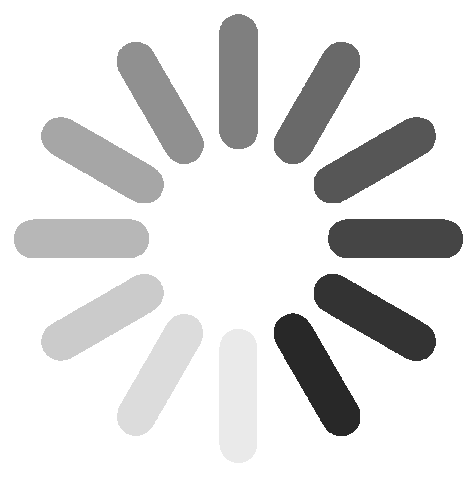

In [40]:

main_plot = datamapplot.create_interactive_plot(
    l3_arr,
    l1_labels,
    l2_labels,
    l3_labels,
    hover_text=hover_labels,
    enable_search=True,
    background_color="#eeeeee",
    label_color_map= custom_color_map,
    marker_size_array=marker_size_array, 
    color_label_text=False
)
main_plot

## Web formatting

Now, we need to add so-called ['Front matter'](https://jekyllrb.com/docs/front-matter/) to the plot to ensure that the plot appears as as single page in our Github Pages. We'll use a function do this, where we define a number of variables that end up within the front matter, and therefore characteristics of the page.

In [41]:

# Defined additional parameters for the front matter to give versatility in the site format
def front_matter(figure,pagetitle,permalink,hidden,target_directory):
    # Define the text to be added at the top of the HTML file
    header_text = f"""---
layout: page
title: {pagetitle}
permalink: /{permalink}/
nav_exclude: {hidden}
---
"""

    # Ensure the target directory exists
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    # Define the full file path
    file_path = os.path.join(target_directory, f"{pagetitle}.html")

    # Save the figure's HTML representation to a file within the target directory
    figure.save(file_path)

    # Read the saved HTML file
    with open(file_path, 'r') as f:
        figure_html = f.read()

    # Combine the header text with the figure's HTML
    full_html = header_text + figure_html

    # Save the combined HTML back to the file in the target directory
    with open(file_path, 'w') as f:
        f.write(full_html)

Test the front-matter addition function by calling it on the `main_plot` generated just above. The plot gives a visual overview of all so-called _functional requirements_.

In [42]:
front_matter(main_plot, 'Functionality Overview', 'FunctionalRequirements','false',os.getcwd()) #Final variable ensures the current working directory (cwd) is used as the target dictory

# Plot Personalization
## Preprocess 'StakeholderDiNo_FRs'

1. Creat standard elements names to match with elements in the 'entries_df'. 

2. Merge 'IT-01' to 'EF-03'

3. Encode the duplicated stakeholders ID (STK-011)

4. Fix #3

5. Rename

In [ ]:
# 1

cols_sh = stakeholders_df.columns

for col in cols_sh:
    #converts it to string format
    stakeholders_df[col] = stakeholders_df[col].astype('string')
    #removes line breaks (\n\r and \n)
    stakeholders_df[col]=stakeholders_df[col].str.replace('\n\r',' ')
    stakeholders_df[col]=stakeholders_df[col].str.replace('\n',' ')

#replaces specific phrases in two columns: changing "User training (online, on site)" to "User training (online/on site)" in column 'U-03', 
# and changing "Local" to "Local device" in column 'IT-04'
stakeholders_df['U-03']=stakeholders_df['U-03'].str.replace('User training (online, on site)','User training (online/on site)')

stakeholders_df['IT-04']=stakeholders_df['IT-04'].str.replace('Local','Local device')
    
# 2
# Combine 'IT-01' and 'EF-03' into a single colum
# Separat by a comma, for each row — but only if at least one of them is not empty
stakeholders_df['EF-03']= stakeholders_df[['EF-03', 'IT-01']].apply(
    lambda row: ', '.join(row.dropna().astype(str)) if row.dropna().size > 0 else pd.NA, axis=1)
stakeholders_df.drop(columns=['IT-01'], inplace=True)

# 3
#creat a column 'count' which acculates the number of times a stakeholder ID appears, starting from 1
stakeholders_df['Count'] = stakeholders_df.groupby('Stakeholder ID').cumcount() + 1
# Create a new column 'TotalCount' that counts the total number of occurrences of each 'Stakeholder ID'
stakeholders_df['TotalCount']=stakeholders_df.groupby('Stakeholder ID')['Stakeholder ID'].transform('count')

#only encode the Stakeholder ID if the total count is greater than 1 
stakeholders_df['New Stakeholder ID'] = stakeholders_df.apply(
    lambda x: x['Stakeholder ID'] + '-' + str(x['Count']).zfill(2) if x['TotalCount'] > 1 else x['Stakeholder ID'],
    axis=1
)

stakeholders_df['Stakeholder ID']=stakeholders_df['New Stakeholder ID']
stakeholders_df.drop(['Count','TotalCount','New Stakeholder ID'],axis=1,inplace=True)

# 4
x_sh = stakeholders_df.shape[0]  #row number
y_sh = stakeholders_df.shape[1]  #column number

# Loop through the stakeholders_df and encode name to items in fix_03 to match the entries_df
for i in range(x_sh):
    for j in range(y_sh):
        if not pd.isna(stakeholders_df.iloc[i, j]) and stakeholders_df.iloc[i, j] in fix_03:
            stakeholders_df.iloc[i, j] = stakeholders_df.iloc[i, j] + '-' + cols[j]

# 5
#remae to matcgh wirh the entries_df
stakeholders_df.rename(columns=rename_dict,inplace=True )



stakeholders_df


,Stakeholder ID,License,Customizable user interface,Languages,Support,Data input,Data import (formats),Data export,Templates,Searchability,...,Preservation of evidence,Compliance,Laboratory management functions,Integrations and extensions,Automation,(Individual) Project management tools,Workflows,Controlled vocabulary,Data access (client),Data storage location
0,STK-003 STK-021 STK-027 STK-043,<NA>,<NA>,<NA>,<NA>,"With internal links, Rich text editor",Image formats,<NA>,"Subject specific templates, Define own templates",<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Local device, Provider's Cloud"
1,STK-020,<NA>,<NA>,<NA>,<NA>,With internal links,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,"Instrument management, LIMS connectivity, Samp...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Local device
2,STK-011-01,<NA>,<NA>,<NA>,<NA>,<NA>,"MS Office formats, Image formats",<NA>,Define own templates,"Tagging, File/data hierarchy, Advanced/conditi...",...,<NA>,<NA>,<NA>,"Protocols.io, One Drive",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,STK-002,<NA>,Yes-U-02,<NA>,User training (online/on site),<NA>,<NA>,Complete content in document format,Define own templates,Advanced/conditional search,...,<NA>,<NA>,"Ordering function, Asset management, Sample Tr...","Slack, Figshare",<NA>,<NA>,<NA>,<NA>,Browser based,Local device
4,STK-045,<NA>,<NA>,<NA>,Online documentation,With external links,MS Office formats,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Browser based,Local device
5,STK-042,<NA>,Yes-U-02,<NA>,<NA>,"Annotation, Rich text editor, Freehand/Sketches","Document formats, Image formats, Structured fo...",<NA>,<NA>,"Advanced/conditional search, File/data hierarchy",...,<NA>,<NA>,"Sample Tracking, Materials database","SnapGene (Dotmatics), One Drive, Dropbox",Autoupload/folder watch,"Task management, Taskboard",<NA>,<NA>,Browser based,"Local device, Provider's Cloud"
6,STK-037,<NA>,<NA>,<NA>,<NA>,Rich text editor,Image formats,<NA>,Define own templates,Advanced/conditional search,...,Audit Trail,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Local device, Provider's Cloud"
7,STK-014,<NA>,<NA>,<NA>,User training (online/on site),<NA>,<NA>,Formats suitable for long term archiving,Define own templates,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Local device, Provider's Cloud"
8,STK-010,<NA>,<NA>,<NA>,User training (online/on site),<NA>,<NA>,<NA>,<NA>,Advanced/conditional search,...,Versioning,<NA>,<NA>,<NA>,"Data analysis, Other API",<NA>,<NA>,<NA>,<NA>,<NA>
9,STK-024,<NA>,Yes-U-02,<NA>,User training (online/on site),<NA>,<NA>,<NA>,Define own templates,"Filtering, Advanced/conditional search, File/d...",...,"Timestamping, Electronic signature, Locking, A...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Yes-IT-03,<NA>,<NA>


Create extra dataframe to build 'marker_alpha_array' and 'marker_color_array'

In [44]:

for i,j in enumerate(l3_labels):
    if j == 'Unlabelled':
        l3_labels[i] = l2_labels[i]
extra_data = pd.DataFrame(
    { 'l1':l1_labels, 'l3':l3_labels}
)

## Full-colour plots

Full-colour versions of personalised plots, where opacity/transparency (`alpha`) is used to indicate where specific attributes are selected.

> __NOTE__ :bangbang: Use of transparency with DataMapPlot in interactive plot is not supported for versions 0.3.0 and below. At the time of writing v0.3.0 is the version available through `conda-forge`. The environment provided therefore loaded datamapplot _last_, via `pip`, to obtain the latest version (0.5.1), into a conda virtual environment

<InteractiveFigure width=100% height=800>
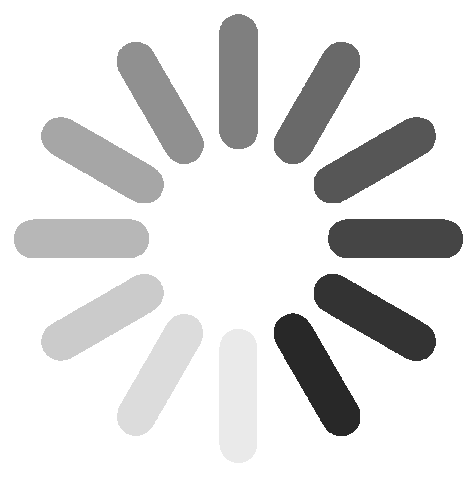

In [ ]:
# creat color_map of l1
unique_l1 = list(set(l1_labels))
ps_color_map = {label: color_map[i % len(color_map)] for i, label in enumerate(unique_l1)}

# creat color_map of l3
l3_color_map = {row['l3']: ps_color_map[row['l1']] for index, row in extra_data.iterrows()}

#creat marker color array     
marker_color_array = extra_data.l3.map(l3_color_map)

# Create a marker alpha array based on the stakeholder contributions
for idx, stakehoder_contri in stakeholders_df.iterrows(): # Iterate over each row in the stakeholder_df
    chosed_items = []
    for col_name, value in stakehoder_contri.iloc[1:].items(): # Iterate over each column in the row except the first one
        if isinstance(value, str) and pd.notna(value): # Check if the value is a string and not NaN
            items = value.split(',') # Split the string into a list of items by comma
            for item in items: # Iterate over each item in the list
                chosed_items.append(item.strip()) # Strip any leading/trailing whitespace from the item


    marker_alpha_array = np.array([0.1 if value not in chosed_items else 1.0 # Set alpha to 0.1 if the value is not in chosed_items 1 for remaining
                                   for value in extra_data['l3']])



    personalized_plot = datamapplot.create_interactive_plot(
        l3_arr,
        l1_labels,
        l2_labels,
        l3_labels,
        hover_text=hover_labels,
        enable_search=True,
        background_color="#eeeeee",
        marker_color_array=marker_color_array,
        marker_alpha_array=marker_alpha_array,
        marker_size_array=marker_size_array, 
        color_label_text=False,
        #enable_table_of_contents=True
        )

    front_matter(personalized_plot,stakehoder_contri["Stakeholder ID"],stakehoder_contri["Stakeholder ID"],'true','_plots')
    
personalized_plot


## Grey version

<InteractiveFigure width=100% height=800>
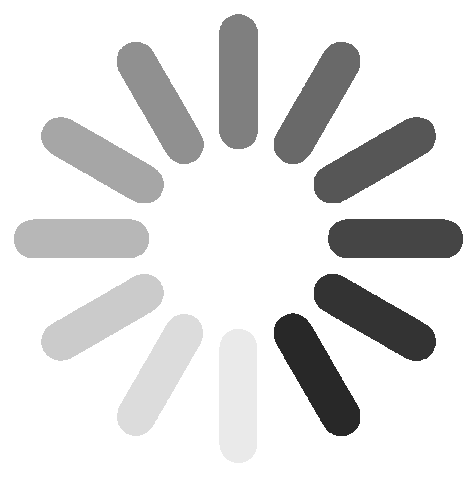

In [46]:

l3_color_map_copy = l3_color_map.copy()



for idx, stakehoder_contri in stakeholders_df.iterrows():
    
    for key in l3_color_map_copy:
        l3_color_map_copy[key] = '#808080'
    chosed_items = []
    for col_name, value in stakehoder_contri.iloc[1:].items():
        if isinstance(value, str) and pd.notna(value):
            items = value.split(',')
            for item in items:
                chosed_items.append(item.strip())

    marker_alpha_array_grey = np.array([0.2 if value not in chosed_items else 1.0
                                   for value in extra_data['l3']])
                
    for item in chosed_items:
        for key, l3_label in l3_color_map_copy.items():
             if item in key:
                 l3_color_map_copy[key] = l3_color_map[key]

    marker_color_array_grey = extra_data.l3.map(l3_color_map_copy)  
    plot_grey = datamapplot.create_interactive_plot(
        l3_arr,
        l1_labels,
        l2_labels,
        l3_labels,
        hover_text=hover_labels,
        enable_search=True,
        background_color="#eeeeee",
        marker_color_array=marker_color_array_grey,
        marker_alpha_array=marker_alpha_array_grey,
        marker_size_array=marker_size_array, 
        color_label_text=False
        )

    front_matter(plot_grey,stakehoder_contri["Stakeholder ID"],stakehoder_contri["Stakeholder ID"],'true','_plots')

              
plot_grey

## Grey version II
Allows for individual plot entry to inspect

<InteractiveFigure width=100% height=800>
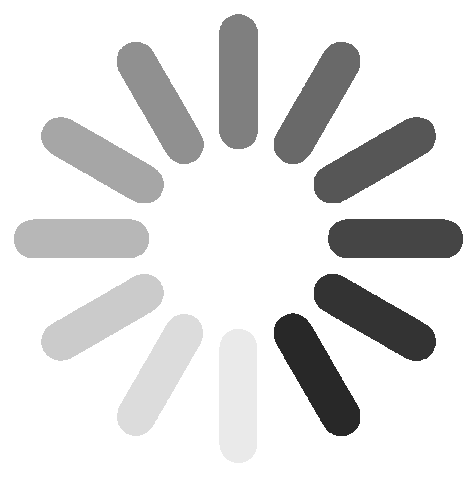

In [47]:
l3_color_map_copy = l3_color_map.copy()
for key in l3_color_map_copy:
        l3_color_map_copy[key] = '#808080'
        
for idx, stakehoder_contri in stakeholders_df[stakeholders_df['Stakeholder ID']=='STK-002'].iterrows():
    
   
    for col_name, value in stakehoder_contri.iloc[1:].items():
        if isinstance(value, str) and pd.notna(value):
            items = value.split(',')
            for item in items:
                chosed_items.append(item.strip())

    marker_alpha_array_grey = np.array([0.2 if value not in chosed_items else 1.0
                                   for value in extra_data['l3']])
                
    for item in chosed_items:
        for key, l3_label in l3_color_map_copy.items():
             if item in key:
                 l3_color_map_copy[key] = l3_color_map[key]

    marker_color_array_grey = extra_data.l3.map(l3_color_map_copy)  
    plot_grey = datamapplot.create_interactive_plot(
        l3_arr,
        l1_labels,
        l2_labels,
        l3_labels,
        hover_text=hover_labels,
        enable_search=True,
        background_color="#eeeeee",
        marker_color_array=marker_color_array_grey,
        marker_alpha_array=marker_alpha_array_grey,
        marker_size_array=marker_size_array, 
        color_label_text=False
        )
    
    # Save the plot with the stakeholder ID in the filename
    front_matter(plot_grey,stakehoder_contri["Stakeholder ID"],stakehoder_contri["Stakeholder ID"],'true','_plots')


plot_grey


